IMPORTS

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

FUNCTIONS

In [2]:
def import_data(month): 
    'input month of interest into function as STRING (yyyymm). Imports data, joins csvs into one dataframe and formats nicely'
    
    # use glob to get all the csv files in the folder
    date_array = [month]
    all_data = pd.DataFrame()

    #loop over all folders for each month
    for date in date_array: 
        path = 'H:\Masters Project\Data First of Month\\' + date
        csv_files = glob.glob(os.path.join(path, "*.csv"))
        print(path)

        #loop over every csv file in each folder
        for f in csv_files:
            # read the csv file
            df = pd.read_csv(f)
            all_data = all_data.append(df)

    print('All csv files loaded to dataframe')
    
    all_data.drop(columns=all_data.columns[0], inplace=True, axis=1)   # remove time axis formatted from PAMGuide
    all_data.replace([np.inf, -np.inf], np.nan, inplace=True)    # replace inf values with nan 
    #all_data.dropna(inplace=True)                                # remove nan values
    all_data.reset_index(inplace=True)                           #reset index
    all_data.drop(columns='index', inplace=True, axis=1)         #remove old index

    return all_data

In [3]:
def remove_nans(df):
    '''
    Removes any rows containing nan values and two rows either side of each of 
    these rows.
    '''
    m = df.isna().any(axis=1)
    return df[~(m | m.shift(fill_value=False) | m.shift(-1, fill_value=False) | m.shift(-2, fill_value=False))]

In [4]:
def broadband_SPL_calc(df): 
    'function that takes in dataframe (containing TOL PAMGuide csv output with time column dropped) and returns'
    'dataframe of the broadband SPL and background for each time interval'
    
    #function to map onto dataframe 
    def broadband_func(x): 
        return 10**(x/10)
    
    #apply function, map to dataframe, sum by row, take the log and then normalise to maximum value of zero 
    SPL = df.applymap(broadband_func)
    SPL_sum = SPL.sum(axis=1)
    broadband_SPL = 10*np.log10(SPL_sum)
    broadband_SPL_normalised = broadband_SPL - np.max(broadband_SPL)
    
    #create dataframe to present results 
    SPL = pd.DataFrame({'broadband_SPL':broadband_SPL_normalised})
    
    #calculate 'background' sound level using moving average
    window = 5*60*2 
    SPL['background' ] = SPL['broadband_SPL'].rolling(window).mean()    
    
    return SPL

In [5]:
def loud_noises(df): 
    'function takes in broadband SPL dataframe and adds label True/False depending if time interval is classified as loud or not'
    'returns original dataframe with loud label and dataframe with just loud noises'
    
    # detection of transient events - example if mean noise of 'crack' is 10% louder than mean background noise 
    df['loud'] = np.where(df['broadband_SPL']>(df['background']+15), True, False)

    #new dataframe of transient events for plotting 
    loud_noise = df[df['loud']==True]
    loud_noise.reset_index(inplace=True)
    
    #prints number of loud noise events as number and percentage of overall time 
    print('Number of loud noise events detected {}, {:.2}% of total time'.format(len(loud_noise), len(loud_noise)/len(df)*100))

    return df, loud_noise

In [7]:
def transients_from_loud(df):
    'FASTER METHOD - inserts new column (transient) with a True / False flag for a transient event '
    
    df['trans_shft_down'] = np.concatenate((np.array([True]), df['loud'][:-1]))
    df['trans_shft_up'] = np.concatenate((df['loud'][1:], np.array([True])))
    df['transient'] = df['loud'] & (df['trans_shft_down']==False) & (df['trans_shft_up']==False)
    df.drop(columns=['trans_shft_down', 'trans_shft_up'], inplace=True)
    
    return df

CODE FOR CHOSEN TIME PERIOD 

In [8]:
df = import_data('201901')  #import data for desired month
df = remove_nans(df)     #remove incorrect data from where hydrophone is not recording 

H:\Masters Project\Data First of Month\201901
All csv files loaded to dataframe


In [9]:
SPL = broadband_SPL_calc(df) #dataframe for broadband SPL values

Number of loud noise events detected 2912, 1.7% of total time


Text(0, 0.5, 'Normalised Broadband SPL dB rel. ')

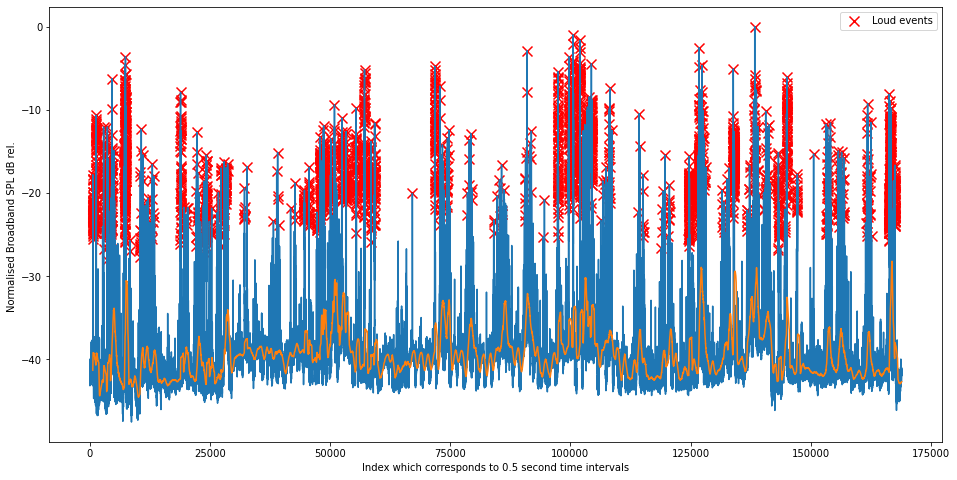

In [10]:
SPL, SPL_loud = loud_noises(SPL)   #add label to detect loud noises 
df = df.join(SPL)    #add broadband SPl and background broadband SPL values to original raw data dataframe (df)

#seperate data frame with just loud events for data analysis and visualisation purposes 
df_loud = df[df['loud']==True]
df_loud.reset_index(inplace=True)

plt.figure(figsize=(16,8))
plt.plot(df['broadband_SPL']) #original data
plt.plot(df['background'])    #background noise 
plt.scatter(x=df_loud['index'], y=df_loud['broadband_SPL'], c='r', marker='x', s=100, label='Loud events')  # loud noises 
plt.legend()
plt.xlabel('Index which corresponds to 0.5 second time intervals')
plt.ylabel('Normalised Broadband SPL dB rel. ')

In [11]:
df = transients_from_loud(df)  #inserts new column with label for transient events 

In [12]:
#seperate data frame with just transient  events for data analysis and visualisation purposes 
df_transient = df[df['transient']==True]
df_transient.reset_index(inplace=True)

PLOTTING

Number of transient noise events detected 478, 0.28% of total time


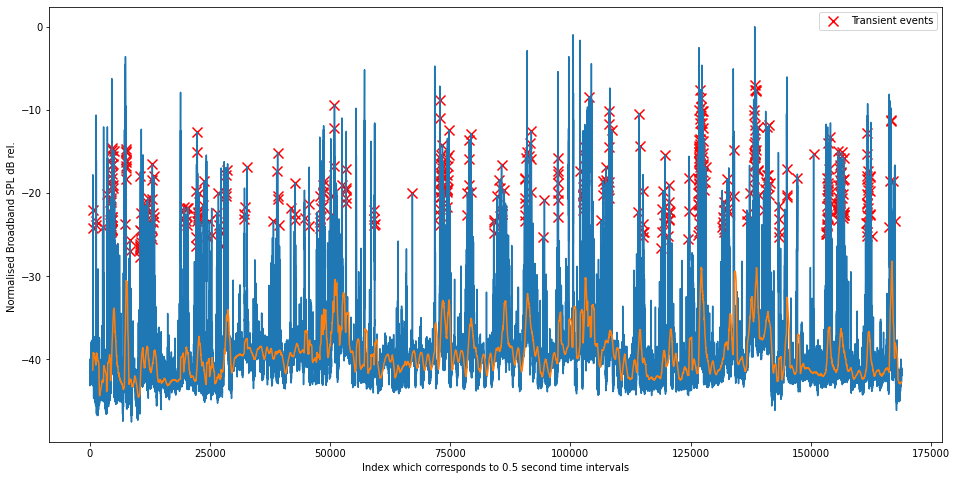

In [13]:
plt.figure(figsize=(16,8))
plt.plot(df['broadband_SPL']) #original data
plt.plot(df['background'])    #background noise 
plt.scatter(x=df_transient['index'], y=df_transient['broadband_SPL'], c='r', marker='x', s=100, label='Transient events')  #transient loud noises 
plt.legend()
plt.xlabel('Index which corresponds to 0.5 second time intervals')
plt.ylabel('Normalised Broadband SPL dB rel. ')

#prints number of transient noise events as number and percentage of overall time 
print('Number of transient noise events detected {}, {:.2}% of total time'.format(len(df_transient), len(df_transient)/len(df)*100))

In [16]:
#creates a new dataframe for continuous loud events - any events that are not classified as transients 
df_continuous = df[(df['transient']!=True) & (df['loud']==True)]
df_continuous.reset_index(inplace=True)

Number of continuous noise events detected 2434, 1.4% of total time


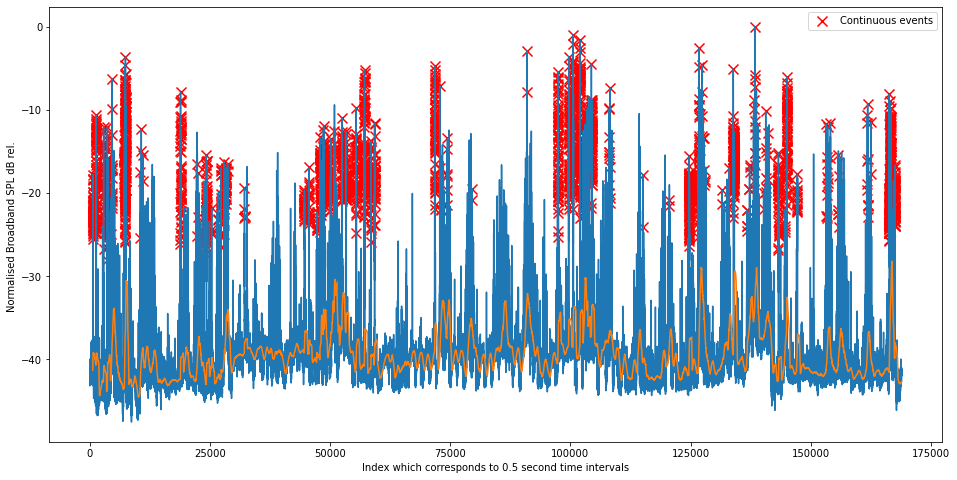

In [17]:
plt.figure(figsize=(16,8))
plt.plot(df['broadband_SPL']) #original data
plt.plot(df['background'])    #background noise 
plt.scatter(x=df_continuous['index'], y=df_continuous['broadband_SPL'], c='r', marker='x', s=100, label='Continuous events')  #transient loud noises 
plt.legend()
plt.xlabel('Index which corresponds to 0.5 second time intervals')
plt.ylabel('Normalised Broadband SPL dB rel. ')


#prints number of transient noise events as number and percentage of overall time 
print('Number of continuous noise events detected {}, {:.2}% of total time'.format(len(df_continuous), len(df_continuous)/len(df)*100))

In [3]:
#SAVE DOWN DATAFRAME AS CSV - change filepath and month filename 
#df.to_csv(r'C:\Users\hjh44\OneDrive - University of Bath\Masters Project\Python\Transient Detection\CSV_output_dataframes\January', index=False)